# Финальный проект.
# Банки — Анализ оттока клиентов

# Материалы:
[Ссылка на дашборд (Tableau)](https://public.tableau.com/app/profile/anasatasia3818/viz/Book1_metan/Dashboard1?publish=yes)

# Описание данных:
Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:
- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- City — город,
- Gender — пол,
- Age — возраст,
- Objects — количество объектов в собственности / equity — количество баллов собственности
- Balance — баланс на счёте,
- Products — количество продуктов, которыми пользуется клиент,
- CreditCard — есть ли кредитная карта,
- Loyalty / last_activity — активный клиент,
- estimated_salary — заработная плата клиента,
- Churn — ушёл или нет.

# Задача (исходная версия от "заказчика"):
- Проанализируйте клиентов регионального банка и выделите сегменты клиентов, которые склонны уходить из банка.
- Проведите исследовательский анализ данных, определите все значимые признаки отточности (интервалы значений характеристик, которые связаны с повышенным оттоком, сравните портреты типичных клиентов, которые склонны и не склонны уходить из банка и т.д)
- Сформулируйте и проверьте статистические гипотезы:
1. Проверьте гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.
2. Сформулируйте и проверьте статистическую гипотезу относительно представленных данных, которая поможет внести ясность в исследование
- Объединяя признаки отточности, сформируйте сегменты, отберите из них лучшие и дайте по ним рекомендации

# Ход работы:
[1.1. Загрузка бибилиотек, импорт данных.](#import)

[1.2. Предобработка. Работа с пропущенными значениями.](#preprocessing)

[2. Исследовательский анализ данных.](#eda)

[Промежуточный итог.](#subtotal)

[3. Сегментация на основе стратегических показателей.](#segment)

[4. Машинное обучение.](#ml)

[5. Формулирование и проверка статистических гипотез.](#stat)

[Выводы и рекомендации для заказчика.](#conclusion)

<a id="import"> </a>
# 1.1. Загрузка бибилиотек, импорт данных.

In [1]:
! pip install phik

     |████████████████████████████████| 679 kB 2.1 MB/s eta 0:00:01


In [2]:
import pandas as pd
from pandas import option_context
import numpy as np

import itertools

import phik

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, mannwhitneyu

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [3]:
bank = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

In [4]:
bank.head(5)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [5]:
def base_info(data):
    
    '''Функция на вход принимает датасет,
    выводит общую информацию о датасете - метод info(),
    количество пропусков в датасете и количество явных дубликатов,
    дополнительно - явные дубликаты удаляются методом drop_duplicates()
    '''
    
    print('общая информация о датасете:')
    print(data.info())
    print('\nпропусков в датасете:')
    print(data.isnull().sum())
    print(f'\nявных дубликатов в датасете:', data.duplicated().sum())
    data = data.drop_duplicates()

In [7]:
base_info(bank)

общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
None

пропусков в датасете:
USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
p

In [8]:
# проверим данные, хранящиеся в столбцах 'score', 'age' и 'city'
# в столбцах 'score' и 'age' нас интересует, есть ли значения с плавающей точкой

print(bank['score'].unique())

print(bank['age'].unique())

print(bank['city'].unique())

[ 850.  861.  892.  866.  730.  856.  807.  825.  923.  906.  927.  921.
  845.  837.  815.  731.  829.  793.  876.  922.  772.  896.  871.  732.
  898.  806.  766.  776.  868.  946.  828.  786.  944.  863.  822.  794.
  924.  811.  814.  956.  935.  826.  849.  901.  893.  792.  888.  831.
  748.  820.  860.  914.  930.  948.  789.  737.  812.  933.  809.  749.
  873.  859.  950.  937.  835.  768.  767.  785.  846.  750.  816.  894.
  891.  788.  758.  787.  821.  855.  779.  791.  838.  971.  797.  841.
  915.  985.  870.  897.  763.  774.  686. 1000.  875.  819.  869.  854.
  810.  761.  802.  958.  917.  745.  736.  908.  928.  884.  853.  780.
  726.  881.  975.  852.  965.  899.  890.  836.  818.  880.  795.  916.
  775.  902.  918.  842.  771.  895.  801.  721.  966.  804.  885.  986.
  753.  832.  979.  798.  754.  756.  823.  658.  734.  954.  827.  929.
  760.  688.  659.  817.  718.  705.  920.  652.  649.  862.  770.  824.
  934.  952.  977.  840.  709.  878.  808.  900.  7

В имеющеймся датасете 10 000 строк, 12 столбцов.

Явных дубликатов - нет.

Пропущенные значения:

в столбце 'age' - 26 строк (слишком мало пропущенных значений на фоне общего количества строк - можно просто удалить),
в столбце 'balance' - 2 295 строк (необходимо подумать, как можно заполнить).
Названия столбцов 'USERID' и 'EST_SALARY' необходимо привести к нижнему регистру.

Значения в столбцах bank['score'] и bank['age'] представлены целыми числами, можно изменить тип данных с 'float' на 'int' (но можно оставить - это ничего не поменяет).

Согласно условию, нам необходимо обучить модель классификации, поэтому категориальные столбцы 'city' и 'gender' необходимо перекодировать.

<a id="preprocessing"> </a>
# 1.2. Предобработка. Работа с пропущенными значениями.

На предыдущем шаге мы выяснили, что в столбце 'balance' пропущено ~23% данных. Попробуем воостановить их с опорой на непустые строки.

# Исследование пропусков.

In [9]:
# для дальнейшего исследования сохраним
# исходный столбец balance (с незаполненными пропущенными значениями)

bank['balance_with_na'] = bank['balance']

Визуализируем распределение переменных в двух группах - группе без пропусков и группе с пропусками в переменной 'balance'. Сравним их между собой, если распределения будут схожи - заполним средней или медианой (Missing At Random). Если распределения отличаются только в разрезе нескольких переменных, то мы можем заполнить пропуски средним значением по группам (Missing At Random). 

В противном случае мы предполагаем, что пропуски возникли из-за неизвестных факторов. В этом случае пропущенные значения лучше удалить.

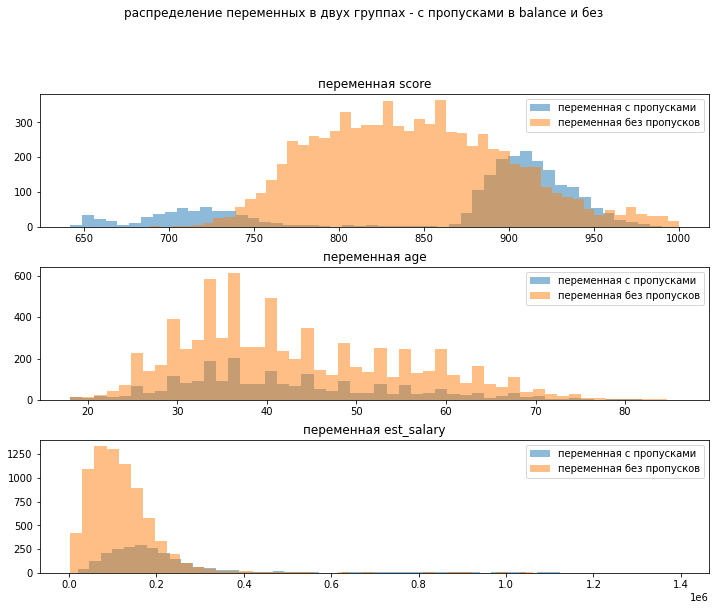

In [10]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.suptitle('распределение переменных в двух группах - с пропусками в balance и без')
ax1 = plt.subplot(4, 1, 1)
plt.title('переменная score')
plt.hist(bank[bank['balance'].isna() == True]['score'], alpha = 0.5, bins=50, label='переменная с пропусками')
plt.hist(bank[bank['balance'].isna() == False]['score'], alpha = 0.5, bins=50, label='переменная без пропусков')
plt.legend(loc='upper right')

ax2 = plt.subplot(4, 1, 2)
plt.title('переменная age')
plt.hist(bank[bank['balance'].isna() == True]['age'], alpha = 0.5, bins=50, label='переменная с пропусками')
plt.hist(bank[bank['balance'].isna() == False]['age'], alpha = 0.5, bins=50, label='переменная без пропусков')
plt.legend(loc='upper right')

ax3 = plt.subplot(4, 1, 3)
plt.title('переменная est_salary')
plt.hist(bank[bank['balance'].isna() == True]['EST_SALARY'], alpha = 0.5, bins=50, label='переменная с пропусками')
plt.hist(bank[bank['balance'].isna() == False]['EST_SALARY'], alpha = 0.5, bins=50, label='переменная без пропусков')
plt.legend(loc='upper right')

plt.show()

In [11]:
city_value_counts_na = pd.concat([pd.DataFrame(bank[bank['balance'].isna() == True]['city'].value_counts(normalize=True)\
                                 .round(2)).T.rename(index={'city': 'with_na'}),
                               pd.DataFrame(bank[bank['balance'].isna() == False]['city'].value_counts(normalize=True)\
                                 .round(2)).T.rename(index={'city': 'without_na'})], axis=0)

gender_value_counts_na = pd.concat([pd.DataFrame(bank[bank['balance'].isna() == True]['gender'].value_counts(normalize=True)\
                                 .round(2)).T.rename(index={'gender': 'with_na'}),
                               pd.DataFrame(bank[bank['balance'].isna() == False]['gender'].value_counts(normalize=True)\
                                 .round(2)).T.rename(index={'gender': 'without_na'})], axis=0)

In [12]:
print('\nсоотношение клиентов в двух группах по городам и полу:')
print(pd.concat([city_value_counts_na, gender_value_counts_na], axis=1))

print('\nсоотношение клиентов в двух группах по количеству недвижимости:')
print(pd.concat([pd.DataFrame(bank[bank['balance'].isna() == True]['equity'].value_counts(normalize=True)\
             .round(2)).T.rename(index={'equity': 'with_na'}),
           pd.DataFrame(bank[bank['balance'].isna() == False]['equity'].value_counts(normalize=True)\
             .round(2)).T.rename(index={'equity': 'without_na'})], axis=0))

print('\nсоотношение клиентов в двух группах по количеству продуктов:')
print(pd.concat([pd.DataFrame(bank[bank['balance'].isna() == True]['products'].value_counts(normalize=True)\
             .round(2)).T.rename(index={'products': 'with_na'}),
           pd.DataFrame(bank[bank['balance'].isna() == False]['products'].value_counts(normalize=True)\
             .round(2)).T.rename(index={'products': 'without_na'})], axis=0))


соотношение клиентов в двух группах по городам и полу:
            Ярославль  Рыбинск  Ростов     М     Ж
with_na          0.64     0.26    0.10  0.56  0.44
without_na       0.57     0.27    0.15  0.48  0.52

соотношение клиентов в двух группах по количеству недвижимости:
               0     1     2    3     4     5     6     7    8    9
with_na     0.95  0.05   NaN  0.0   NaN   NaN   NaN   NaN  NaN  NaN
without_na  0.05  0.09  0.14  0.2  0.24  0.25  0.02  0.01  0.0  0.0

соотношение клиентов в двух группах по количеству продуктов:
              0     1     2     3     4    5
with_na     0.0  0.85  0.14  0.01   NaN  NaN
without_na  NaN  0.18  0.62  0.13  0.06  0.0


В двух группах (с пропусками и без) мы наблюдаем схожее распредление переменных age, city, gender.

Изучим корреляцию, найдем переменные связанные с balance.

In [13]:
# создадим фиктивную переменную, где 0 будет отмечен пропуск в балансе, а 1 - не пропуск

bank['balance_dummy'] = bank['balance_with_na'].fillna(0)

bank.loc[(bank['balance_dummy'] != 0), ('balance_dummy')] = 1

In [14]:
# закодируем категориальные переменные 
# для дальнейшего исследования сохраним исходные значения переменных

bank = pd.concat([bank, pd.get_dummies(bank[['city', 'gender']], drop_first=True)], axis=1)

In [15]:
bank_balance_phik = round(bank.drop(['USERID', 'balance', 'balance_with_na'], axis=1).phik_matrix(), 2)

bank_balance_phik['balance_dummy'].sort_values(ascending=False)

interval columns not set, guessing: ['score', 'age', 'equity', 'products', 'credit_card', 'last_activity', 'EST_SALARY', 'churn', 'balance_dummy', 'city_Рыбинск', 'city_Ярославль', 'gender_М']


balance_dummy     1.00
equity            0.98
products          0.79
score             0.75
EST_SALARY        0.43
churn             0.38
credit_card       0.25
gender            0.10
gender_М          0.10
city_Ярославль    0.09
age               0.05
city              0.04
last_activity     0.04
city_Рыбинск      0.01
Name: balance_dummy, dtype: float64

Баланс коррелирует с баллами недвижимости, количеством продуктов, скорингом, зарплатой, фактом оттока и кредитной картой. 

Попробуем заполнить пропуски двумя способами:
- наивным - при помощи возраста, города и пола,
- и при помощи корреляции.

# Заполнение пропусков.

In [17]:
# посчитаем медианные значения зарплаты в разрезе города, пола и возраста

naive_balance = bank.groupby(['age', 'city', 'gender'])['balance'].median()

In [18]:
# разобьем на отрезки score и  est_salary

bank['est_salary_qcut'] = pd.qcut(bank['EST_SALARY'], 15)
bank['score_qcut'] = pd.qcut(bank['score'], 15)

In [19]:
balance_corr = bank.groupby(['equity', 'products', 'score_qcut', 'est_salary_qcut', 
                             'churn', 'credit_card'])['balance'].median().round(2).reset_index()

In [21]:
# объединим датафрейм и сводные таблицы

bank = bank.merge(naive_balance, how='left', on=['age', 'city', 'gender'], 
                  suffixes=('', '_pivot_naive'))


bank = bank.merge(balance_corr, how='left', on=['equity', 'products', 'score_qcut', 'est_salary_qcut', 
                                                'churn', 'credit_card'], 
                  suffixes=('', '_pivot_corr'))

In [22]:
# заполним пропуски данными из сводных таблиц

bank['balance_fill_naive'] = bank['balance_with_na'].fillna(bank['balance_pivot_naive'], axis=0)

bank['balance_fill_corr'] = bank['balance_with_na'].fillna(bank['balance_pivot_corr'], axis=0)

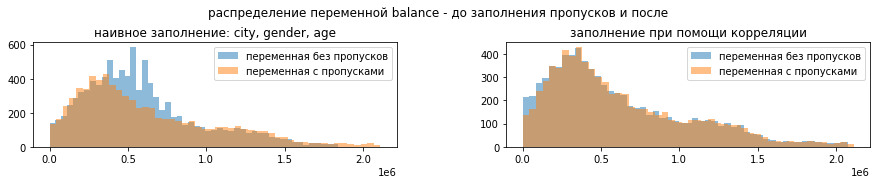

In [23]:
# визуализируем и сравним распределение исходной переменной balance с заполненными двумя способами

plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

plt.suptitle('распределение переменной balance - до заполнения пропусков и после')

ax1 = plt.subplot(2, 2, 1)
plt.title('наивное заполнение: city, gender, age')
plt.hist(bank[bank['balance_fill_naive'] <= np.nanpercentile(bank['balance_fill_naive'], 95)]['balance_fill_naive'], 
         alpha = 0.5, bins=50, label='переменная без пропусков')
plt.hist(bank[bank['balance'] <= np.nanpercentile(bank['balance'], 95)]['balance'], 
         alpha = 0.5, bins=50, label='переменная с пропусками')
plt.legend(loc='upper right')

ax2 = plt.subplot(2, 2, 2)
plt.title('заполнение при помощи корреляции')
plt.hist(bank[bank['balance_fill_corr'] <= np.nanpercentile(bank['balance_fill_corr'], 95)]['balance_fill_corr'], 
         alpha = 0.5, bins=50, label='переменная без пропусков')
plt.hist(bank[bank['balance'] <= np.nanpercentile(bank['balance'], 95)]['balance'], 
         alpha = 0.5, bins=50, label='переменная с пропусками')
plt.legend(loc='upper right')

plt.show()

Второй вариант сработал лучше - новое распределение во многом повторяет исходное, необъяснимых пиков - нет.

In [24]:
print('пропусков в balance:', bank['balance_fill_corr'].isnull().sum())
print('пропусков в age:', bank['age'].isnull().sum())

пропусков в balance: 2068
пропусков в age: 26


Итого: мы имеем 2068 пропуска в balance и 26 - в age.
    
Удалим пропущенные значения в age, а так же вспомогательный столбцы, незаполненные строки в balance оставим без изменения:

In [25]:
bank['balance'] = bank['balance_fill_corr']

bank = bank.dropna(subset=['age']).drop(columns=['balance_dummy', 'est_salary_qcut', 'score_qcut', 'balance_pivot_naive',
                                               'balance_pivot_corr', 'balance_fill_naive', 'balance_fill_corr'])

In [26]:
# переименуем необходимые столбцы

bank = bank.rename(columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary',
                           'city_Рыбинск': 'city_rybinsk', 'city_Ярославль': 'city_yaroslavl', 
                            'gender_М': 'gender_m'})

In [27]:
print('длина датасета после удаления пропусков:', bank.shape[0])

длина датасета после удаления пропусков: 9974


В исходных данных мы наблюдали пропуски в столбцах age и balance (~23% пропущенных значений). Пропуски в age было решено оставить без изменения и просто удалить.

Пропуски в balance были частично заполнены медианными значениями в разрезе количества недвижимости и продуктов, факта оттока, наличия кредитной карты и разбитых на отрезки 'score' и 'est_salary'.

После удаления оставшихся пропущенных значений в датасете осталось 9 974 строк.

<a id="eda"> </a>
# 2. Исследовательский анализ данных.

# min, max, median

In [28]:
# проверим минимальные, медианные и максимальные значения переменных
# бинарные переменные пока не учитываем

bank[['score', 'age', 'equity', 'balance', 'products', 'est_salary']].agg(['min', 'median', 'max'])

,score,age,equity,balance,products,est_salary
min,642.0,18.0,0.0,0.000000e+00,0.0,2546.300
median,853.0,40.0,3.0,5.069249e+05,2.0,119626.795
max,1000.0,86.0,9.0,1.191136e+08,5.0,1395064.450


In [29]:
# изучим бинарные переменные

pd.concat([bank['churn'].value_counts(), bank['credit_card'].value_counts(), bank['last_activity'].value_counts()], axis=1)

,churn,credit_card,last_activity
0,8155,3190,4759
1,1819,6784,5215


Целевая переменная ('churn') несбалансированна - неотточных клиентов больше, чем отточных (~80/20).

Клиенты, имеющие кредитную карту, составляют треть от имеющейся выборки.

Активных и неактивных клиентов примерно поровну. Согласно условию, клиенты промаркированные как активные (last_activity = 1) явно сообщают нам о желании покинуть банк, но пока не уходят.

# Корреляция

Изучим корреляцию между признаками и визуализируем ее. Для удобства на графиках подсветим только умеренную корреляцию (|0.1| и выше).

In [30]:
bank_phik = round(bank.drop(['user_id', 'city', 'gender'], axis=1).phik_matrix(), 2)

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn', 'balance_with_na', 'city_rybinsk', 'city_yaroslavl', 'gender_m']


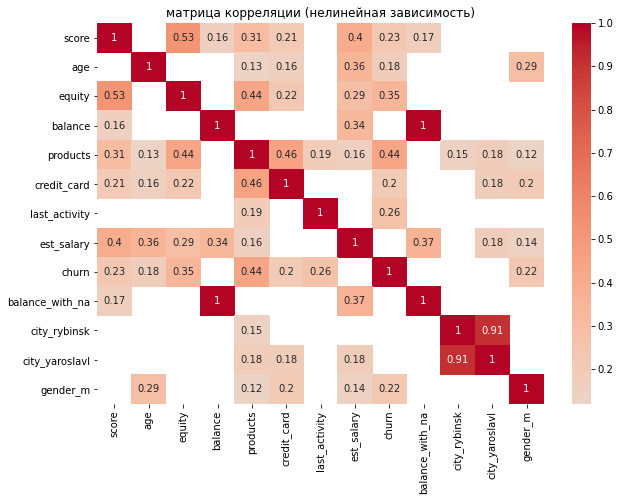

In [31]:
# визуализируем матрицу phik-корреляции и "подсветим" переменные с корреляцией 0.1 и выше

plt.subplots(figsize=(10, 7))
sns.heatmap(bank_phik[bank_phik > 0.1], annot=True, cmap='coolwarm', center=0)
plt.title('матрица корреляции (нелинейная зависимость)')
plt.show();

In [32]:
# выделим из phik-матрицы столбец с перменной 'churn'

bank_phik[bank_phik['churn'] > 0.1]['churn'].sort_values(ascending=False)

churn            1.00
products         0.44
equity           0.35
last_activity    0.26
score            0.23
gender_m         0.22
credit_card      0.20
age              0.18
Name: churn, dtype: float64

Phik нашла взимосвязь факта оттока с количеством продуктов и баллами недвижимости, а так же с активность, скорингом, полом, наличием кредитной карты и возрастом.

Мы можем предположить, что мы сможем сегментировать наших пользователей по этим переменным.

# Визуализация переменных: числовые значения

Все графики дополним вертикальными линиями, которые будут отмечать пороговые значения для повышенного оттока.

In [33]:
score_bins = [i for i in range(int(bank['score'].min()), int(bank['score'].max()) + 1, 5)]

age_bins = [i for i in range(int(bank['age'].min()), int(bank['age'].max()) + 1, 2)]

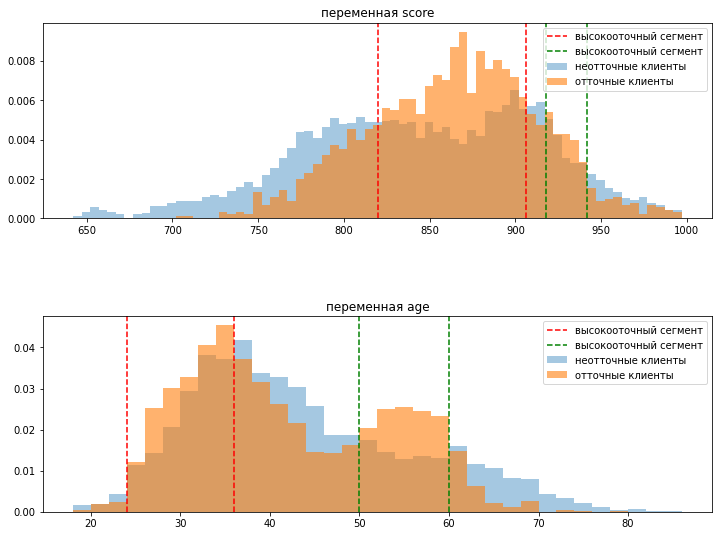

In [34]:
# визуализируем переменные score, age в разрезе факта оттока

plt.figure(figsize=(12,9))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

ax1 = plt.subplot(2, 1, 1)
plt.title('переменная score')
plt.hist(bank[bank['churn'] == 0]['score'], alpha = 0.4, label='неотточные клиенты', density=True, bins=score_bins)
plt.hist(bank[bank['churn'] == 1]['score'], alpha = 0.6, label='отточные клиенты', density=True, bins=score_bins)
plt.axvline(x=820, color='red', linestyle='--', label='высокооточный сегмент') 
plt.axvline(x=906, color='red', linestyle='--')
plt.axvline(x=918, color='green', linestyle='--', label='высокооточный сегмент') 
plt.axvline(x=942, color='green', linestyle='--')
plt.legend(loc='upper right')


ax2 = plt.subplot(2, 1, 2)
plt.title('переменная age')
plt.hist(bank[bank['churn'] == 0]['age'], alpha = 0.4, label='неотточные клиенты', density=True, bins=age_bins)
plt.hist(bank[bank['churn'] == 1]['age'], alpha = 0.6, label='отточные клиенты', density=True, bins=age_bins)
plt.axvline(x=24, color='red', linestyle='--', label='высокооточный сегмент', c='r') 
plt.axvline(x=36, color='red', linestyle='--', c='r')
plt.axvline(x=50, color='red', linestyle='--', c='g', label='высокооточный сегмент',)
plt.axvline(x=60, color='red', linestyle='--', c='g')
plt.legend(loc='upper right')
plt.show()

На графике видны наиболее отточные сегменты - это клиентом с рейтингом ~820-906 и 918-942 и возрастые группы 24-36 и 50-60.

In [35]:
# для удобства (и сокращения длины кода) в отдельную переменную строки с непустыми значения баланса

balance_without_na = bank.copy()
balance_without_na = balance_without_na[balance_without_na['balance'].isna() == False]

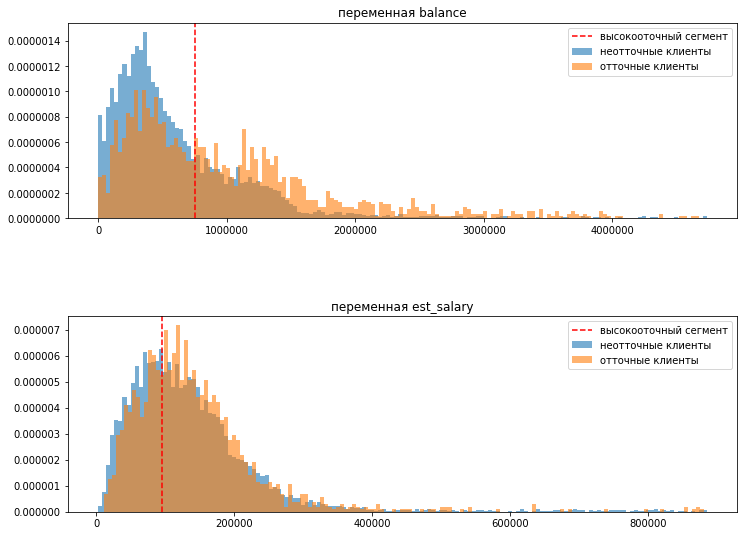

In [36]:
# визуализируем переменные balance, est_salary в разрезе факта оттока
# "обрежем" для удобства значения до 99 перцентиля


plt.figure(figsize=(12,9))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

ax1 = plt.subplot(2, 1, 1)
plt.title('переменная balance')
plt.ticklabel_format(axis='both', style='plain')
plt.hist(balance_without_na[(balance_without_na['churn'] == 0) & 
                            (balance_without_na['balance'] <= np.percentile(balance_without_na['balance'], 99))]['balance'],
         alpha = 0.6, label='неотточные клиенты', density=True, bins=150)
plt.hist(balance_without_na[(balance_without_na['churn'] == 1) 
                            & (balance_without_na['balance'] <= np.percentile(balance_without_na['balance'], 99))]['balance'],
         alpha = 0.6, label='отточные клиенты', density=True, bins=150)
plt.axvline(x=750000, color='red', linestyle='--', label='высокооточный сегмент') 
plt.legend(loc='upper right')

ax2 = plt.subplot(2, 1, 2)
plt.title('переменная est_salary')
plt.ticklabel_format(axis='both', style='plain')
plt.hist(bank[(bank['churn'] == 0) & (bank['est_salary'] <= np.percentile(bank['est_salary'], 99))]['est_salary'],
         alpha = 0.6, label='неотточные клиенты', density=True, bins=150)
plt.hist(bank[(bank['churn'] == 1) & (bank['est_salary'] <= np.percentile(bank['est_salary'], 99))]['est_salary'],
         alpha = 0.6, label='отточные клиенты', density=True, bins=150)
plt.axvline(x=95000, color='red', linestyle='--', label='высокооточный сегмент') 
plt.legend(loc='upper right')

plt.show()

Чем выше у клиента зарплата и баланс, тем выше шанс того, что он попадет в категорию отточных.

При подсчете минимума и максимума, мы увидели аномально большие максимальные значения переменных, график выше это подтверждает - распределения признаков скошены вправо.

Повышенный отток мы ожидаем у групп клиентов с балансом более 750 000 и зарплатой ~ 95 000.

Рассмотрим переменные при помощи боксплота:

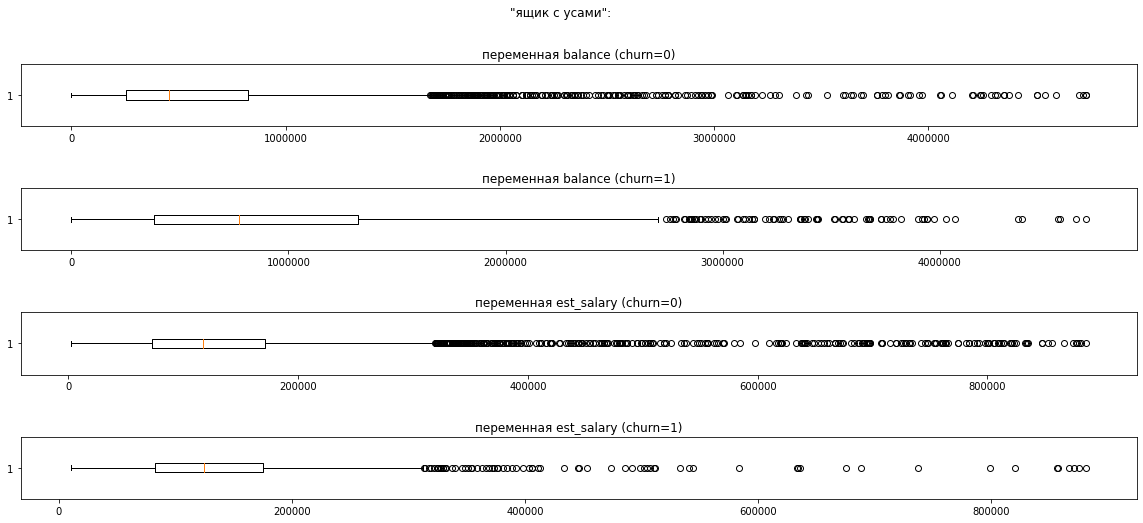

In [37]:
# визуализируем переменные balance, est_salary в разрезе факта оттока
# "обрежем" для удобства значения до 99 перцентиля

plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=1, hspace=1)
plt.suptitle('"ящик с усами":')
ax1 = plt.subplot(4, 1, 1)
plt.title('переменная balance (churn=0)')
plt.ticklabel_format(style = 'plain')
plt.boxplot(balance_without_na[(balance_without_na['churn'] == 0) 
                            & (balance_without_na['balance'] <= np.percentile(balance_without_na['balance'], 99))]['balance'], 
            vert=False)

ax2 = plt.subplot(4, 1, 2)
plt.title('переменная balance (churn=1)')
plt.ticklabel_format(style = 'plain')
plt.boxplot(balance_without_na[(balance_without_na['churn'] == 1) 
                             & (balance_without_na['balance'] <= np.percentile(balance_without_na['balance'], 99))]['balance'], 
            vert=False)

ax3 = plt.subplot(4, 1, 3)
plt.title('переменная est_salary (churn=0)')
plt.ticklabel_format(style = 'plain')
plt.boxplot(bank[(bank['churn'] == 0) & (bank['est_salary'] <= np.percentile(bank['est_salary'], 99))]['est_salary'], 
            vert=False)

ax4 = plt.subplot(4, 1, 4)
plt.title('переменная est_salary (churn=1)')
plt.ticklabel_format(style = 'plain')
plt.boxplot(bank[(bank['churn'] == 1) & (bank['est_salary'] <= np.percentile(bank['est_salary'], 99))]['est_salary'], 
            vert=False)


plt.show();

Для двух переменных (зарплата и баланс) мы можем наблюдать схожие черты:
- в группе неотточных клиентов медиана меньше, чем в группе отточных,
- максимальные значения переменных больше в группе отточных клинетов, но у неотточных больше выбросов,
- межквартильный размах шире в группах отточных клиентов.

# Визуализация переменных: категориальные переменные

Для визуализации проведем небольшую подгтовительную работу:
- посчитаем процент оттока по банку,
- для переменных city, gender, credit_card, last_activity, equity и products построим сводные таблицы, посчитаем значения с разбивкой по факту оттока (методом value_counts), дополнительно - для каждой категории подсчитаем процент оттока и сравним его с общебанковским. Если процент оттока в какой-либо категории будет сильно отличаться от остальных - отметим его в качестве потенциального признака для сегментации,
- визуализируем полученные таблицы.

In [38]:
city_value_counts =\
    [[city, round(bank[bank['city'] == city]['churn'].mean() * 100, 2)] for city in bank['city'].unique()]


city_churn_perc = pd.DataFrame(city_value_counts, columns=['city', 'churn_perc'])\
                    .sort_values(by='churn_perc', ascending=False)
city_churn_perc.set_index('city', inplace=True)
city_churn_perc

,churn_perc
city,
Ярославль,19.01
Ростов,18.71
Рыбинск,16.29


Процент оттока по городам примерно одинаковый, в Ярославле чуть выше.

In [39]:
gender_value_counts =\
    [[gender, round(bank[bank['gender'] == gender]['churn'].mean() * 100, 2)] for gender in bank['gender'].unique()]

    
gender_churn_perc = pd.DataFrame(gender_value_counts, columns=['gender', 'churn_perc'])\
                      .sort_values(by='churn_perc', ascending=False)
gender_churn_perc.set_index('gender', inplace=True)
gender_churn_perc

,churn_perc
gender,
М,23.70
Ж,12.76


Мужчины покидают банк почти в два раза чаще, чем женщины.

In [40]:
card_value_counts =\
    [[card, round(bank[bank['credit_card'] == card]['churn'].mean() * 100, 2)] for card in bank['credit_card'].unique()]

activ_value_counts =\
    [[activ, round(bank[bank['last_activity'] == activ]['churn'].mean() * 100, 2)] for activ in bank['last_activity'].unique()]

card_churn_perc = pd.DataFrame(card_value_counts, columns=['card_bool', 'card_churn'])
activ_churn_perc = pd.DataFrame(activ_value_counts, columns=['last_activity_bool', 'activ_churn'])

card_churn_perc.set_index('card_bool', inplace=True)
card_churn_perc

,card_churn
card_bool,
0,25.58
1,14.78


Клиенты без кредитной карты чаще покидают банк.

In [41]:
activ_churn_perc.set_index('last_activity_bool', inplace=True)
activ_churn_perc

,activ_churn
last_activity_bool,
1,24.49
0,11.39


Клиенты, проявлявшие в последнее время активность, уходят в два раза чаще.

In [42]:
equity_value_counts =\
    [[equity, round(bank[bank['equity'] == equity]['churn'].mean() * 100, 2)] for equity in bank['equity'].unique()]

equity_churn_perc = pd.DataFrame(equity_value_counts, columns=['equity_count', 'equity_churn'])
equity_churn_perc.sort_values(by='equity_churn', ascending=False)

equity_churn_perc.set_index('equity_count', inplace=True)
equity_churn_perc

,equity_churn
equity_count,
1,12.03
5,30.08
0,3.49
4,25.12
3,20.90
2,15.79
6,36.02
7,46.25
8,35.29


С ростом числа недвижимости, процент оттока растет.

In [43]:
products_value_counts =\
    [[products, round(bank[bank['products'] == products]['churn'].mean() * 100, 2)] for products in bank['products'].unique()]

products_churn_perc = pd.DataFrame(products_value_counts, columns=['products_count', 'products_churn'])
products_churn_perc = products_churn_perc[products_churn_perc['products_count'] != 0]\
            .sort_values(by='products_count', ascending=True).set_index('products_count')
products_churn_perc

,products_churn
products_count,
1,7.07
2,19.11
3,28.61
4,63.29
5,42.11


Чаще всего банк покидают владельцы 2 и более продуктов.

In [65]:
# в отдельную переменную сохраним средний отток по банку

bank_churn_mean = bank['churn'].mean() * 100

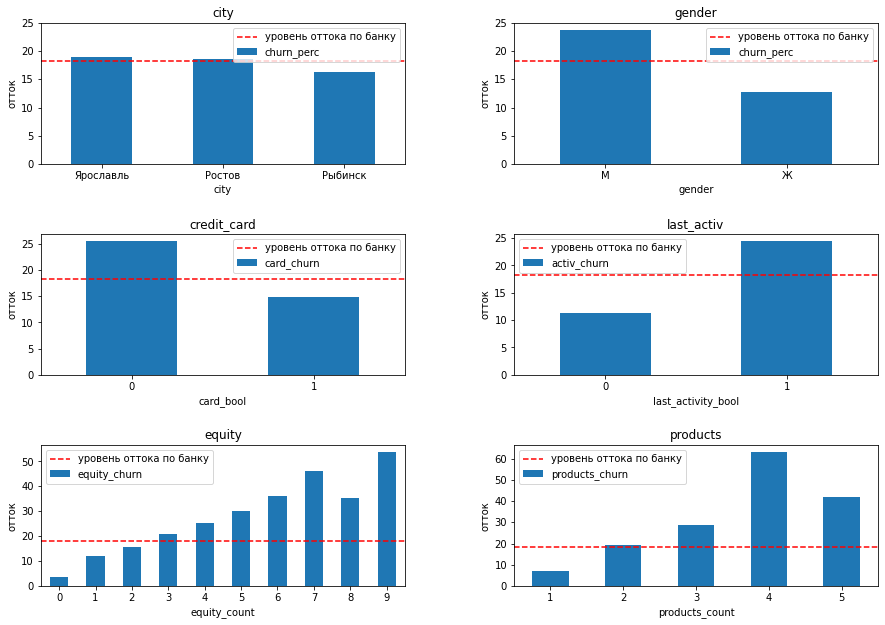

In [66]:
# визуализируем категориальные переменные

plt.figure(figsize=(15, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

ax1 = plt.subplot(6, 2, 1)
city_churn_perc.plot(kind = 'bar', rot=0, title='city', ax=ax1, ylabel='отток')
plt.axhline(y=bank_churn_mean, linestyle='--', color='r', label='уровень оттока по банку')
plt.legend(loc='upper right')
plt.ylim(0, 25)

ax2 = plt.subplot(6, 2, 2)
gender_churn_perc.plot(kind = 'bar', rot=0, title='gender', ax=ax2, ylabel='отток')
plt.axhline(y=bank_churn_mean, linestyle='--', color='r', label='уровень оттока по банку')
plt.legend()
plt.ylim(0, 25)


ax3 = plt.subplot(6, 2, 3)
card_churn_perc.sort_index().plot(kind = 'bar', rot=0, title='credit_card', ax=ax3, ylabel='отток')
plt.axhline(y=bank_churn_mean, linestyle='--', color='r', label='уровень оттока по банку')
plt.legend()


ax4 = plt.subplot(6, 2, 4)
activ_churn_perc.sort_index().plot(kind = 'bar', rot=0, title='last_activ', ax=ax4, ylabel='отток')
plt.axhline(y=bank_churn_mean, linestyle='--', color='r', label='уровень оттока по банку')
plt.legend()


ax5 = plt.subplot(6, 2, 5)
equity_churn_perc.sort_index().plot(kind = 'bar', rot=0, title='equity', ax=ax5, ylabel='отток')
plt.axhline(y=bank_churn_mean, linestyle='--', color='r', label='уровень оттока по банку')
plt.legend()


ax6 = plt.subplot(6, 2, 6)
products_churn_perc.sort_index().plot(kind = 'bar', rot=0, title='products', ax=ax6, ylabel='отток')
plt.axhline(y=bank_churn_mean, linestyle='--', color='r', label='уровень оттока по банку')
plt.legend()

plt.show()

Вернемся к score, age, balance и est_salary - посчитаем процент оттока в группах, которые мы смогли обнаружить на графиках:
- возраст - 24-36 и 50-60.
- кредитный рейтинг - ~820-906 и ~918-942
- баланс - более 750 000,
- зарплата - более 95 000.

Посчитаем отток в каждой группе, сравним с остальными

In [45]:
print(\
    'age', '\nотток в группе < 24:',
    round(bank[bank['age'] < 24]['churn'].mean() * 100, 2),
    '\nотток в группе 24 - 36 (отток):',
    round(bank[(bank['age'] >= 24) & (bank['age'] <= 36)]['churn'].mean() * 100, 2),
    '\nотток в группе 37 - 49:',
    round(bank[(bank['age'] >= 37) & (bank['age'] <= 49)]['churn'].mean() * 100, 2),
    '\nотток в группе 50 - 60 (отток):',
    round(bank[(bank['age'] >= 50) & (bank['age'] <= 60)]['churn'].mean() * 100, 2),
    '\nотток в группе > 60:',
    round(bank[bank['age'] > 60]['churn'].mean() * 100, 2))

age 
отток в группе < 24: 12.24 
отток в группе 24 - 36 (отток): 20.74 
отток в группе 37 - 49: 15.22 
отток в группе 50 - 60 (отток): 26.47 
отток в группе > 60: 6.49


In [46]:
print(\
    'score', '\nотток в группе < 820:',
    round(bank[bank['score'] < 820]['churn'].mean() * 100, 2),
    '\nотток в группе 820 - 906 (отток):',
    round(bank[(bank['score'] >= 820) & (bank['score'] <= 906)]['churn'].mean() * 100, 2),
    '\nотток в группе 907 - 917:',
    round(bank[(bank['score'] >= 907) & (bank['score'] <= 917)]['churn'].mean() * 100, 2),
    '\nотток в группе 918 - 942 (отток):',
    round(bank[(bank['score'] >= 918) & (bank['score'] <= 942)]['churn'].mean() * 100, 2),
    '\nотток в группе > 942:',
    round(bank[bank['score'] > 942]['churn'].mean() * 100, 2))

score 
отток в группе < 820: 10.74 
отток в группе 820 - 906 (отток): 24.25 
отток в группе 907 - 917: 16.83 
отток в группе 918 - 942 (отток): 20.54 
отток в группе > 942: 12.19


In [47]:
print(\
      'est_salary', '\nотток в группе < 95 000:',
      round(bank[bank['est_salary'] < 95000]['churn'].mean() * 100, 2),
      '\nотток в группе >= 95 000:',
      round(bank[bank['est_salary'] >= 95000]['churn'].mean() * 100, 2))

est_salary 
отток в группе < 95 000: 15.81 
отток в группе >= 95 000: 19.62


In [48]:
print(\
      'balance', '\nотток в группе < 750 000:',
      round(bank[bank['balance'] < 750000]['churn'].mean() * 100, 2),
      '\nотток в группе >= 750 000:',
      round(bank[bank['balance'] >= 750000]['churn'].mean() * 100, 2))

balance 
отток в группе < 750 000: 16.58 
отток в группе >= 750 000: 34.84


Дополнительно - разобьем баланс на отрезки, посчитаем отток на каждом отрезке и визуализируем результат. 

In [49]:
b_cut_labels = ['0 - 250 000', '250 000 - 500 000', '500 000 - 750 000', '750 000 - 1 000 000', 
                '1 000 000 - 1 250 000',  '1 250 000 - 1 500 000', '> 1 500 000']

bank['balance_cut'] = pd.cut(x=bank['balance'], 
                             bins=[0, 250000, 500000, 750000, 1000000, 1250000, 1500000, bank['balance'].max()],
                            labels=b_cut_labels)

In [50]:
balance_cut_value_counts =\
    [[cut, round(bank[bank['balance_cut'] == cut]['churn'].mean() * 100, 2)] for cut in b_cut_labels]

balance_cut_churn_perc = pd.DataFrame(balance_cut_value_counts).dropna()
balance_cut_churn_perc.columns = ['balance_cut', 'churn_perc']
balance_cut_churn_perc.set_index('balance_cut', inplace=True)

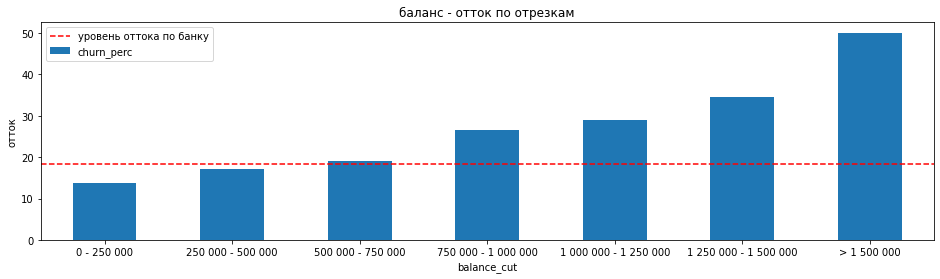

In [70]:
balance_cut_churn_perc.plot(kind = 'bar', rot=0, title='баланс - отток по отрезкам', 
                                         ylabel='отток', figsize=(16,4))
plt.axhline(y=bank_churn_mean, linestyle='--', color='r', label='уровень оттока по банку')
plt.legend()
plt.show()

Наши предположения подтвердились - отток растет с ростом баланса клиентов, максимальный отток - у клиентов с самым высоким балансом.

<b>Потенциальные признаки отточных клиентов.</b>

Изучив данные, мы обнаружили, что:
- самый высокий уровень оттока в группе пользователей, которые заявляли о своем желание уйти,
- мужчины чаще покидают банк чем женщины,
- пользователи из Ярославля наиболее многочисленные, отток по городам примерно одинаковый,
- чаще уходят клиенты с кредитным рейтингом ~820-906 и ~918-942,
- с зарпалатой больше 95 000,
- с балансом более 750 000,
- чаще отточными становятся клиенты, имеющие четыре банковских продукта,
- наиболее отточные возрастные группы - 24-36 и 50-60.
- банк реже покидают владельцы кредитных карт,
- с ростом количества недвижимости растет процент оттока.

Вопросы вызывает переменная balance - мы заполняли пропуски в столбце средними значениями по группам, полностью доверятся этим данным нельзя. 

Посчитаем разницу значений признаков между двумя категориями - отточными и неотточными.

# Исследование портретов отточных и неотточных клиентов (средние и медианы)

In [59]:
bank_columns = ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 
                'est_salary', 'city_rybinsk', 'city_yaroslavl', 'gender_m']

In [60]:
# посчитаем средние значения переменных в разрезе факта оттока
# так же - разницу в двух группах (diff_mean) и модуль разницу (diff_mean_abs)

churn_mean = pd.concat([pd.DataFrame(bank[bank['churn'] == 0][bank_columns].mean())\
                                .rename(columns={0: 'churn_0_mean'}).round(2),
                        pd.DataFrame(bank[bank['churn'] == 1][bank_columns].mean())\
                                .rename(columns={0: 'churn_1_mean'}).round(2)],
                              axis=1)


bank_mean = pd.concat([pd.DataFrame(bank[bank_columns].mean())\
                                .rename(columns={0: 'bank_mean'}).round(2),
                             churn_mean],
                             axis=1)


bank_mean['diff_mean'] = (bank_mean['churn_1_mean'] / bank_mean['churn_0_mean'] * 100 - 100).round(2)
bank_mean['diff_mean_abs'] = bank_mean['diff_mean'].abs()

In [61]:
# посчитаем медиану в разрезе факта оттока
# так же - разницу в двух группах (diff_median) и модуль разницу (diff_median_abs)

#churn_median = pd.concat([pd.DataFrame(bank[bank['churn'] == 0][bank_columns].median())\
#                                .rename(columns={0: 'churn_0_median'}).round(2),
#                        pd.DataFrame(bank[bank['churn'] == 1][bank_columns].median())\
#                                .rename(columns={0: 'churn_1_median'}).round(2)],
#                              axis=1)


#bank_median = pd.concat([pd.DataFrame(bank[bank_columns].median())\
#                                .rename(columns={0: 'bank_median'}).round(2),
#                             churn_median],
#                             axis=1)


#bank_median['diff_median'] = (bank_median['churn_1_median'] / bank_median['churn_0_median'] * 100 - 100).round(2)
#bank_median['diff_median_abs'] = bank_median['diff_median'].abs()

#bank_median.fillna(0, inplace=True)
#bank_median.replace([np.inf, -np.inf], 0, inplace=True)

# bank_median

In [62]:
print('портреты клиентов - средние значения:')
bank_mean.sort_values(by='diff_mean_abs', ascending=False)

портреты клиентов - средние значения:


,bank_mean,churn_0_mean,churn_1_mean,diff_mean,diff_mean_abs
balance,806503.29,709613.61,1134458.21,59.87,59.87
equity,2.63,2.38,3.76,57.98,57.98
last_activity,0.52,0.48,0.70,45.83,45.83
gender_m,0.50,0.47,0.65,38.30,38.30
products,1.87,1.76,2.38,35.23,35.23
credit_card,0.68,0.71,0.55,-22.54,22.54
city_rybinsk,0.27,0.28,0.24,-14.29,14.29
city_yaroslavl,0.59,0.58,0.61,5.17,5.17
age,42.73,43.02,41.45,-3.65,3.65
score,848.68,845.40,863.42,2.13,2.13


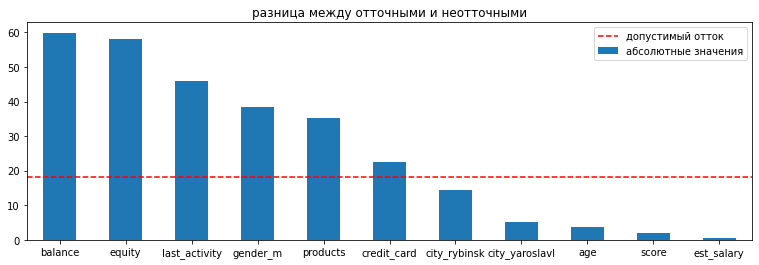

In [69]:
# визуализируем процентнуб разницу в двух группах - отточных и неотточных
# горизонтальной линией отметим 10% - максимально допустимый отток по банку

plt.figure(figsize=(13,4))

bank_mean['diff_mean_abs'].sort_values(ascending=False).plot(kind = 'bar', rot=0, 
                                                             title='разница между отточными и неотточными')
plt.axhline(y=bank_churn_mean, linestyle='--', c='r')
plt.legend(['допустимый отток', 'абсолютные значения'], loc='upper right')


plt.show()

Сравнив абсолютные значения разницы переменных в двух группах (отточные и неотточные), мы можем сегментировать наших клиентов по:
- балансу,
- количеству баллов недвижимости,
- отметке об активности,
- полу
- и количеству продуктов.

<a id="subtotal"> </a>
# Промежуточный итог.

Соберем в одну таблицу значения корреляции, портретную разницу, отточные интервалы, обнаруженные на графиках, и вынесем вердикт, какие переменные мы будем использовать в качестве сегментации.

In [57]:
df_list = [bank_phik['churn'], bank_mean['diff_mean_abs']]


eda_summarize = pd.concat(df_list, axis=1).set_axis(['phik_corr', 'diff_mean_abs'], axis=1)\
                                          .sort_values(by='diff_mean_abs', ascending=False)

eda_summarize.dropna(inplace=True)

In [58]:
linear_connection = ['есть связь', 'есть связь', 'есть связь', 'есть связь', 'есть связь',\
                     'есть связь', 'нет связи', 'нет связи', 'есть связь', 'есть связь', 'нет связи']

churn_interval = ['> 750 000', '> 2 - растет с увеличением количества', 'активный клиент (1)', 'пол = мужской',
                  '4 продукта', 'нет кредитки (0)', '-', '-', '24-36 и 50-60', '820-906 и 918-942 баллов',
                  '< 95 000']

client_portrait = ['есть связь', 'есть связь', 'есть связь', 'есть связь', 'есть связь',\
                   'есть связь', 'есть связь', 'нет связи', 'нет связи', 'нет связи', 'нет связи']

verdict = ['используем', 'используем', 'используем', 'не используем', 'используем', 'используем', 'не используем',
           'не используем', 'под вопросом', 'под вопросом', 'не используем']

eda_summarize.insert(loc=2 , column='корреляция_с_целевой', value=linear_connection)
eda_summarize.insert(loc=3 , column='отточный_интервал', value=churn_interval)
eda_summarize.insert(loc=4 , column='сравнение портретов', value=client_portrait)
eda_summarize.insert(loc=5 , column='вердикт', value=verdict)

eda_summarize

,phik_corr,diff_mean_abs,корреляция_с_целевой,отточный_интервал,сравнение портретов,вердикт
balance,0.03,59.87,есть связь,> 750 000,есть связь,используем
equity,0.35,57.98,есть связь,> 2 - растет с увеличением количества,есть связь,используем
last_activity,0.26,45.83,есть связь,активный клиент (1),есть связь,используем
gender_m,0.22,38.30,есть связь,пол = мужской,есть связь,не используем
products,0.44,35.23,есть связь,4 продукта,есть связь,используем
credit_card,0.20,22.54,есть связь,нет кредитки (0),есть связь,используем
city_rybinsk,0.04,14.29,нет связи,-,есть связь,не используем
city_yaroslavl,0.03,5.17,нет связи,-,нет связи,не используем
age,0.18,3.65,есть связь,24-36 и 50-60,нет связи,под вопросом
score,0.23,2.13,есть связь,820-906 и 918-942 баллов,нет связи,под вопросом


Для сегментации нам подоходят переменные balance, equity, last_activity, products и credit_card.

Перспективным кажутся переменные score и age, мы обнаружили корреляцию с целевой переменной, но не обнаружили разницу между портретами - можно проверить ее дополнительно.

<a id="segment"> </a>
# 3. Сегментация на основе стратегических показателей.

In [59]:
# создадим словарь с значениями отточных интервалов

segment_dict = {'last_activity == 1': 'last_activity == 1', 
                'gender == М': 'gender == "М"', 
                'balance < 750 000': 'balance <750000',
                'est_salary >= 95 000': 'est_salary >= 95000', 
                'products == 4': 'products == 4', 
                'credit_card == 0': 'credit_card == 0',
                'equity >= 2': 'equity >= 2', 
                'age - 24-36': '24 <= age <= 36', 
                'age - 50-60': '50 <= age <= 60',
                'score - 820-906': '820 <= score <= 906',
                'score - 918-942': '918 <= score <= 942'}

In [60]:
# получим неповторяющиеся комбинации отточных интервалов для сегментации

comb_list_2 = list(itertools.combinations(segment_dict.items(), 2))
comb_list_3 = list(itertools.combinations(segment_dict.items(), 3))

print('количество комбинаций из 4 признаков:', len(comb_list_2))
print('количество комбинаций из 5 признаков:', len(comb_list_3))

количество комбинаций из 4 признаков: 55
количество комбинаций из 5 признаков: 165


In [61]:
def churn_data(comb_list, data_churn):
    
    '''Функция принимает на вход список комбинаций из отточных признаков и столбец исходного датафрейма
    с общим оттоком по банку.
    Функция:
    1. превращает комбинации отточных признаков в строку и использует ее в качестве среза по исходному датафрейму,
    2. для каждого среза подсчитывает общее количество клиентов в сегменте, количество отточных клиентов,
       процент оттока по сегменту, дополнительно - создает столбцы с маркировкой значений в зависимости от условий 
       и удаляет строки с сегментами, в которые не вошло ни одного клиента.
    
    Возвращает:
    - датафрейм с подсчитанным оттоком по всем комбинациям признаков,
    - датафрейм с комбинациями с самым высоким оттоком, с оптимальным размером сегмента и большим количеством 
      отточных клиентов  (топ-5).'''
    
    
    string_query = []
    data = []
    
    for i in range(0, len(comb_list)):
        if len(comb_list[0]) == 2:
            string = comb_list[i][0][1] + ' & ' + comb_list[i][1][1]
            string_query.append(string)
        if len(comb_list[0]) == 3:
            string = comb_list[i][0][1] + ' & ' + comb_list[i][1][1] + ' & ' + comb_list[i][2][1]
            string_query.append(string)
    
    for q in string_query:
        total_in_segment_count = bank.query(q).shape[0]
        churn_in_segment_count = round(bank.query(q))['churn'].sum()
        churn_in_segment = round(bank.query(q)['churn'].mean() * 100, 2)
        data.append([q, total_in_segment_count, churn_in_segment_count, churn_in_segment])
        
    df = pd.DataFrame(data, columns=['features', 'total_count', 'churn_count', 
                                     'churn_perc'])
    df.dropna(inplace=True)
    
    def churn_rating(row):
        min_churn = data_churn.mean() * 1.5 * 100
        medium_churn = data_churn.mean() * 2 * 100
        max_churn = data_churn.mean() * 3 * 100

        if row < min_churn:
            return 'недостаточно отточный сегмент'
        if min_churn <= row <= medium_churn:
            return 'не высокоотточный сегмент'
        else:
            return 'высокоотточный сегмент'
    
    
    def total_in_segment_rating(row):
        if row >= 3000:
            return 'слишком много клиентов - эффективность снизится'
        if row < 1000:
            return 'слишком мало клиентов'
        else:
            return 'оптимальный размер'
    
    
    def churn_in_segment_rating(row):
        share_catched = row / data_churn.mean()
        if share_catched < 1/3:
            return 'недостаточно отточных'
        if 1/2 < share_catched < 2/3:
            return 'достаточно отточных'
        else:
            return 'высокоотточный сегмент'
    
    
    df['оценка оттока'] = df['churn_perc'].apply(churn_rating)   
    df['количество отточных'] = df['churn_count'].apply(churn_in_segment_rating)   
    df['размер сегмента'] = df['total_count'].apply(total_in_segment_rating)

    best_features_comb = df[(df['размер сегмента'] == 'оптимальный размер') & 
                            (df['количество отточных'] == 'высокоотточный сегмент') &
                            (df['оценка оттока'].isin(['не высокоотточный сегмент', 'высокоотточный сегмент']))]\
                        .iloc[0:, [0, 2, 3]]\
                        .sort_values(by='churn_perc', ascending=False).head(7).reset_index(drop=True)

    return df, best_features_comb

In [62]:
# применим функцию к комбинациям признаков 
# на выходе получим датафреймы с наилучшими комбинациями признаков и высоким уровнем оттока

two_features_perc, two_features_best_comb = churn_data(comb_list_2, bank['churn'])

three_features_perc, three_features_best_comb = churn_data(comb_list_3, bank['churn'])

In [63]:
with option_context('display.max_colwidth', 70):
    print(two_features_best_comb)

                                   features  churn_count  churn_perc
0  last_activity == 1 & 820 <= score <= 906          833       36.11
1     last_activity == 1 & credit_card == 0          612       35.07
2          gender == "М" & credit_card == 0          457       35.07
3             equity >= 2 & 50 <= age <= 60          417       34.29
4    credit_card == 0 & 820 <= score <= 906          533       31.69
5       gender == "М" & 820 <= score <= 906          688       31.03
6            credit_card == 0 & equity >= 2          764       30.99


In [64]:
with option_context('display.max_colwidth', 70):
    print(three_features_best_comb)

                                                         features  \
0          last_activity == 1 & equity >= 2 & 820 <= score <= 906   
1        last_activity == 1 & gender == "М" & 820 <= score <= 906   
2                last_activity == 1 & gender == "М" & equity >= 2   
3          last_activity == 1 & est_salary >= 95000 & equity >= 2   
4             last_activity == 1 & credit_card == 0 & equity >= 2   
5              last_activity == 1 & equity >= 2 & 24 <= age <= 36   
6  last_activity == 1 & est_salary >= 95000 & 820 <= score <= 906   

   churn_count  churn_perc  
0          788       44.57  
1          476       44.03  
2          714       43.59  
3          836       43.07  
4          580       42.71  
5          535       42.33  
6          575       41.76  


Комбинации из трех признаков показали себя лучше, чем комбинации из двух. В обоих случаях мы выбирали комбиции удовлетворяющие двух условиям:
- размер сегментов должен быть оптимальным (от 1 000 до 3 000 клиентов),
- уровень оттока в этих сегментах минимум в 1.5 раза превышает общебанковский.

Мы наблюдаем схожие черты во всех высооточных сегментах:
- наиболее отточные клиенты сообщают о том, что они хотят покинуть банк (last_activity == 1),
- скоринг отточных клиентов довольно высокий (820-906),
- чаще всего нас покидают мужчины,
- у части пользователей нет кредитной карты (особенно это заметно в комбинациях из двух признаков),
- отточные клиенты владеют более 2 объектов недвижимости
- и получают зарплалту более 95 000.

Попробуем уплотнить несколько схожих топовых комбинаций из трех признаков:

In [65]:
bank.query('last_activity == 1 & equity >= 2 & 820 <= score <= 906 & gender == "М"')['churn'].mean()

0.5640394088669951

In [66]:
bank.query('last_activity == 1 & gender == "М" & equity >= 2  & est_salary >= 95000')['churn'].mean()

0.49700598802395207

In [67]:
bank.query('last_activity == 1 & credit_card == 0 & equity >= 2 & 24 <= age <= 36')['churn'].mean()

0.5486725663716814

# Портреты высокоотных сегментов:
Мы можем выделить три наиболе отточных сегмента:

<b>первый:</b>
- клиенты сообщали о своем желании уйти,
- клиенты владеют более 2 объектов недвижимости,
- довольно высокий скоринг таких клиентов - 820 - 906,
- опционально - если клиенты мужчины, то шанс, что они уйдут - повышается;

<b>второй:</b>
- клиенты сообщали о своем желании уйти,
- клиенты владеют более 2 объектов недвижимости,
- клиенты - мужчины
- опционально - зарплата более 95 000 повышает шанс оттока;

<b>третий:</b>
- клиенты сообщали о своем желании уйти,
- клиенты владеют более 2 объектов недвижимости,
- клиенты не заводят кредитную карту,
- опционально - клиенты молодого возраста (24 - 36).

<a id="ml"> </a>
# 4. Машинное обучение.

Проведем подготовительную работу:
- создадим функцию, которая будет выводить нам значения метрик,
- выделим зависимую (целевую) переменную и независимые,
- стандартизируем данные для построения модели логистической регрессии,
- разобьем данные на train и test в пропорции 70 / 30.

In [69]:
def model_metrics(model, x_test, y_test, predictions):
    
    '''функция принимает на вход модель машинного обучения, значения x_test, y_test и предсказания
    и печатает значения метрик (accuracy, precision, recall, F1 score, ROC AUC)'''
    
    model_probability = model.predict_proba(x_test)[:,1]
    
    print('Precision: {:.3f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.3f}'.format(recall_score(y_test, predictions)))
    print('F1 score: {:.3f}'.format(f1_score(y_test, predictions)))
    print('ROC AUC: {:.3f}'.format(roc_auc_score(y_test, model_probability)))

Поскольку нам важно правильно классифицировать объекты положительного класса, метрика precision станет для нас основной, recall скажет о том, какую долю объектов мы смогли детектировать. Так же будем обращать внимание на f1 score - метрика даст нам представление о точности и полноте алгоритма.

In [70]:
# подготовим переменные

x_y = bank.drop(columns=['user_id', 'city', 'gender', 'balance_with_na', 'balance_cut'], axis=1).dropna()

X = x_y.drop(columns=['churn'], axis=1)
y = x_y['churn']

In [71]:
# разобьем данные на test и train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [72]:
# стандартизируем данные для работы с логистической регрессией

scaler = StandardScaler() 

scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# Логистическая регрессия.

In [73]:
# обучим модель логистической регрессии

lr_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

lr_model.fit(X_train_st, y_train)

predictions_lr = lr_model.predict(X_test_st)

In [74]:
print('LogisticRegression:')

model_metrics(lr_model, X_test_st, y_test, predictions_lr)

LogisticRegression:
Precision: 0.647
Recall: 0.301
F1 score: 0.411
ROC AUC: 0.781


Модель показала невысокие значения метрики - она смогла обнаружить только 28.6% объектов первого класса и правильно детектировала 68.6% из них.

In [75]:
annot_text = np.array(['true negative', 'false positive', 'false negative', 'true positive']).reshape(2, 2)

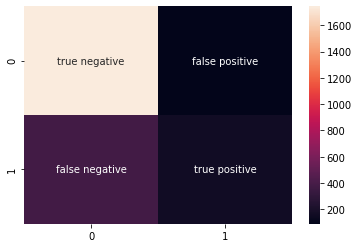

In [76]:
sns.heatmap(confusion_matrix(y_test, predictions_lr), 
            annot=annot_text, fmt="")
plt.show()

In [77]:
# изучим коэффициенты, посмотрим, какие признаки модель посчитала неважными и занулила

lr_model_coef = pd.concat([pd.DataFrame(lr_model.coef_).T, pd.DataFrame(X.columns)], axis=1)

lr_model_coef.columns = ['coef_lr', 'features']
lr_model_coef.set_index('features', inplace=True)
lr_model_coef

,coef_lr
features,
score,0.431207
age,-0.122848
equity,0.187236
balance,-0.001781
products,0.359908
credit_card,-0.198662
last_activity,0.569707
est_salary,0.046570
city_rybinsk,-0.068801


Модель посчитала неважными и занулила большую часть коэффициентов. Больше всего на предсказание влияют переменные last_activity,  gender_m, score и products - схожие результаты мы получили при помощи корреляции Спирмана.

# Decision Tree - подбор параметров.

In [78]:
best_dt_model = None
best_dt_params = []
best_dt_result = 0

In [79]:
%%time

# подберем параметры модели в цикле

for depth in range(1, 10):
    for samples_split in range(2, 10):
        for samples_leaf in range(1, 10):
            for crit in ['gini', 'entropy']:
                dt_tree = DecisionTreeClassifier(random_state=42, 
                                                 max_depth=depth, 
                                                 criterion=crit,
                                                 min_samples_split=samples_split, 
                                                 min_samples_leaf=samples_leaf)
                dt_tree.fit(X_train, y_train)
                predictions = dt_tree.predict(X_test)
                
                result = precision_score(y_test, predictions, zero_division=0)

                if result > best_dt_result:
                    best_dt_model = dt_tree
                    best_dt_result = result
                    best_dt_params = [depth, crit, samples_split, samples_leaf]

CPU times: user 22.1 s, sys: 79.2 ms, total: 22.2 s
Wall time: 22.5 s


In [80]:
print('Decision Tree Classifier:')

print(f'precision наилучшей модели на тестовой выборке: {best_dt_result}',
      f'max_depth: {best_dt_params[0]}',
      f'criterion: {best_dt_params[1]}',
      f'min_samples_split: {best_dt_params[2]}',
      f'min_samples_leaf:  {best_dt_params[3]}', sep='\n')  

Decision Tree Classifier:
precision наилучшей модели на тестовой выборке: 0.7864077669902912
max_depth: 2
criterion: gini
min_samples_split: 2
min_samples_leaf:  1


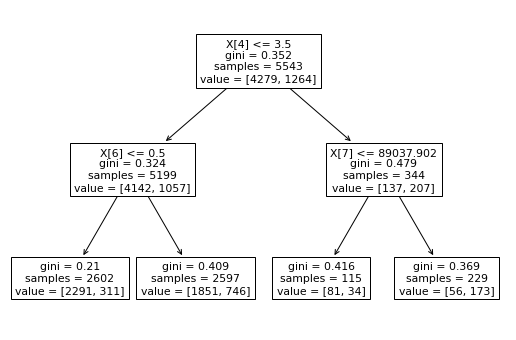

In [81]:
# визуализируем дерево решений

plt.figure(figsize=(9,6))
plot_tree(best_dt_model)
plt.show()

In [82]:
print('модель разделила пользователей по переменным:', [X.columns[4], X.columns[6], X.columns[7]])

модель разделила пользователей по переменным: ['products', 'last_activity', 'est_salary']


In [83]:
# сохраним коэффициенты

best_dt_model_coef = pd.concat([pd.DataFrame(best_dt_model.feature_importances_), pd.DataFrame(X.columns)], axis=1)

best_dt_model_coef.columns = ['coef_dt', 'features']
best_dt_model_coef.set_index('features', inplace=True)
best_dt_model_coef

,coef_dt
features,
score,0.000000
age,0.000000
equity,0.000000
balance,0.000000
products,0.492638
credit_card,0.000000
last_activity,0.351693
est_salary,0.155669
city_rybinsk,0.000000


Дерево решений занулило большую часть коэффицентов.

In [84]:
best_dt_model.fit(X_train, y_train)

best_dt_model_predictions = best_dt_model.predict(X_test)

model_metrics(best_dt_model, X_test, y_test, best_dt_model_predictions)

Precision: 0.786
Recall: 0.149
F1 score: 0.251
ROC AUC: 0.686


precision выше, чем у логистической регрессии, но остальные метрики - хуже.

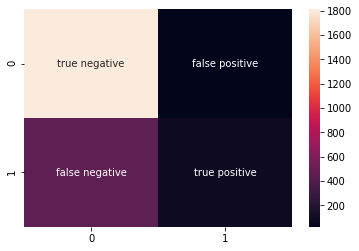

In [85]:
sns.heatmap(confusion_matrix(y_test, best_dt_model_predictions), 
            annot=annot_text, fmt="")
plt.show()

# Random Forest - подбор параметров.

In [86]:
best_rf_model = None
best_rf_result = 0
best_rf_params = []

In [87]:
%%time

# подберем параметры модели в цикле

for est in range(1, 10):
    for depth in range(1, 10):
        for samples_split in range(2, 10):
            for samples_leaf in range(1, 10):
                for crit in ['gini', 'entropy']:
                    r_forest = RandomForestClassifier(random_state=42,
                                                      n_estimators=est,
                                                      max_depth=depth,
                                                      criterion=crit,
                                                      min_samples_split=samples_split,
                                                      min_samples_leaf=samples_leaf)
                    r_forest.fit(X_train, y_train)
                    predictions = r_forest.predict(X_test)
                    
                    result = precision_score(y_test, predictions, zero_division=0)
    
                    if result > best_rf_result:
                        best_rf_model = r_forest
                        best_rf_result = result
                        best_rf_params = [est, depth, crit, samples_split, samples_leaf]

CPU times: user 5min 20s, sys: 1.82 s, total: 5min 22s
Wall time: 5min 26s


In [88]:
print('Random Forest Classifier:')

print(f'precision наилучшей модели на тестовой выборке: {best_rf_result}',
      f'n_estimators: {best_rf_params[0]}',
      f'max_depth: {best_rf_params[1]}',
      f'criterion: {best_rf_params[2]}',
      f'min_samples_split: {best_rf_params[3]}',
      f'min_samples_leaf:  {best_rf_params[4]}', sep='\n')  

Random Forest Classifier:
precision наилучшей модели на тестовой выборке: 1.0
n_estimators: 5
max_depth: 2
criterion: gini
min_samples_split: 2
min_samples_leaf:  1


In [89]:
# сохраним коэффициенты модели

best_rf_model_coef = pd.concat([pd.DataFrame(best_rf_model.feature_importances_), pd.DataFrame(X.columns)], axis=1)

best_rf_model_coef.columns = ['coef_rf', 'features']
best_rf_model_coef.set_index('features', inplace=True)
best_rf_model_coef

,coef_rf
features,
score,0.251938
age,0.050640
equity,0.047121
balance,0.244194
products,0.127415
credit_card,0.000000
last_activity,0.248196
est_salary,0.000000
city_rybinsk,0.000000


Бо́льший вес получили переменные: score, last_activity, products и balance, меньший - age, gender_m, credit_card, est_salary и equity. Модель занулила переменные, связанные с городом.

In [90]:
# обучим модель, получим предсказания

best_rf_model.fit(X_train_st, y_train)

best_rf_model_predictions = best_rf_model.predict(X_test_st)

In [91]:
print('Random Forest Classifier:')

model_metrics(best_rf_model, X_test_st, y_test, best_rf_model_predictions)

Random Forest Classifier:
Precision: 1.000
Recall: 0.011
F1 score: 0.022
ROC AUC: 0.770


Из трех моделей, лес показал себя лучше остальных - precision и roc auc - выше, чем у остальных моделей.

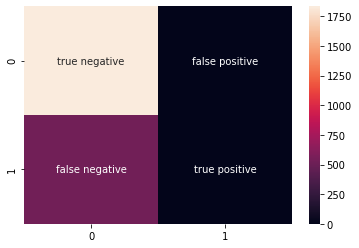

In [92]:
sns.heatmap(confusion_matrix(y_test, best_rf_model_predictions), 
            annot=annot_text, fmt="")
plt.show()

# Изучим коэффициенты, полученные в результате работы трех моделей

In [93]:
model_list = [best_rf_model_coef, best_dt_model_coef, lr_model_coef]

pd.concat(model_list, axis=1)

,coef_rf,coef_dt,coef_lr
features,,,
score,0.251938,0.000000,0.431207
age,0.050640,0.000000,-0.122848
equity,0.047121,0.000000,0.187236
balance,0.244194,0.000000,-0.001781
products,0.127415,0.492638,0.359908
credit_card,0.000000,0.000000,-0.198662
last_activity,0.248196,0.351693,0.569707
est_salary,0.000000,0.155669,0.046570
city_rybinsk,0.000000,0.000000,-0.068801


Все три модели однозначно посчитали, что перменные products и last_activity - важны для прогноза. Регрессиия и лес посчитали важными score, а решающее дерево выбрало важным переменную est_salary.

Полученные коэффициенты перекликаются с нашими результатами, полученными графически и при помощи корреляции.

<a id="stat"> </a>
# 5. Формулирование и проверка статистических гипотез.

t-тест сравнивает средние значения двух выборок и сообщает, отличаются они или нет. Нас интересует значение p-value, которое покажет вероятность того, что отличия в двух выборках случайны. Чем меньше это значение и ближе к нулю - тем лучше.

Требования t-теста:
- нормальное распределение данных (строгое требование),
- дисперсия двух выборок равна,
- данные являются независимыми и непрерывными.

Критерий Манна-Уитни не такой строгий, но он не проверяет ничего, кроме равенства распределений. Этот критерий не подходит для сравнения средних или медиан. 

<b>Гипотеза 1 - "проверьте гипотезу различия доходов между теми клиентами, которые ушли и теми, которые остались".</b>

<b>H0:</b> различий дохода между двумя группами нет.

<b>Н1:</b> доход в группах ушедших клиентов и оставшихся различается.

In [94]:
# установим уровень статзначимости

alpha = 0.05

дисперсия 
churn=0: 20358839437.94 | churn=1: 15112316536.37


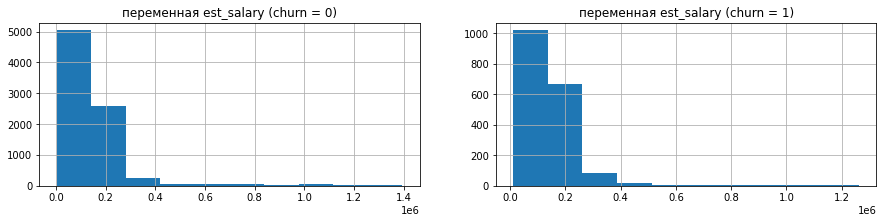

In [95]:
print('дисперсия', '\nchurn=0:', round(bank[bank['churn'] == 0]['est_salary'].var(), 2), '|'
      ' churn=1:', round(bank[bank['churn'] == 1]['est_salary'].var(), 2))

plt.figure(figsize=(15,3))

ax1 = plt.subplot(1, 2, 1)
plt.title('переменная est_salary (churn = 0)')
bank[bank['churn'] == 0]['est_salary'].hist()

ax2 = plt.subplot(1, 2, 2)
plt.title('переменная est_salary (churn = 1)')
bank[bank['churn'] == 1]['est_salary'].hist()

plt.show()

In [96]:
# посчитаем p-value двумя тестами
# сравним с уровнем стат. значимости

ttest_balance = ttest_ind(bank[bank['churn'] == 0]['est_salary'], bank[bank['churn'] == 1]['est_salary'], 
                          equal_var=False, alternative='two-sided')

mannwhitneyu_balance = mannwhitneyu(bank[bank['churn'] == 0]['est_salary'], bank[bank['churn'] == 1]['est_salary'])


pval_balance = {'ttest': ttest_balance.pvalue, 'mannwhitneyu': mannwhitneyu_balance.pvalue}


for key, value in pval_balance.items():
    if value < alpha:
        print(key, ': отвергаем нулевую гипотезу - доход в группах ушедших клиентов и оставшихся различается.')
        print('p-value:', value)
    else:
        print(key, ': различий дохода между двумя группами нет.')
        print('p-value:', value)

ttest : различий дохода между двумя группами нет.
p-value: 0.8515799588935961
mannwhitneyu : отвергаем нулевую гипотезу - доход в группах ушедших клиентов и оставшихся различается.
p-value: 0.0001941125216825749


Графически, при помощи корреляции и при помощи моделей мы установили связь скоринга с целевой переменной, но при сравнении портретов мы не смогли обнаружить различий. 

Проверим наше предположение о различии скоринга при помощи статистических тестов.

<b>Гипотеза 2 - "проверьте гипотезу различия скоринга между теми клиентами, которые ушли и теми, которые остались".</b>

<b>H0:</b> различий скоринга между двумя группами нет.

<b>Н1:</b> скоринг в группах ушедших клиентов и оставшихся различается.

дисперсия 
churn=0: 4623.06 | churn=1: 2462.24


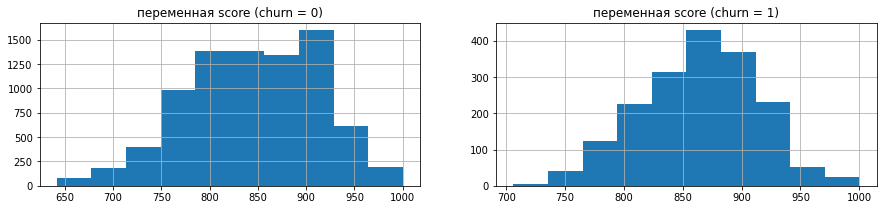

In [97]:
print('дисперсия', '\nchurn=0:', round(bank[bank['churn'] == 0]['score'].var(), 2), '|'
      ' churn=1:', round(bank[bank['churn'] == 1]['score'].var(), 2))

plt.figure(figsize=(15,3))

ax1 = plt.subplot(1, 2, 1)
plt.title('переменная score (churn = 0)')
bank[bank['churn'] == 0]['score'].hist()

ax2 = plt.subplot(1, 2, 2)
plt.title('переменная score (churn = 1)')
bank[bank['churn'] == 1]['score'].hist()

plt.show()

In [98]:
ttest_score = ttest_ind(bank[bank['churn'] == 0]['score'], bank[bank['churn'] == 1]['score'], 
                          equal_var=False, alternative='two-sided')

mannwhitneyu_score = mannwhitneyu(bank[bank['churn'] == 0]['score'], bank[bank['churn'] == 1]['score'])


pval_score = {'ttest': ttest_score.pvalue, 'mannwhitneyu': mannwhitneyu_score.pvalue}


for key, value in pval_score.items():
    if value < alpha:
        print(key, ': отвергаем нулевую гипотезу - скоринг в группах ушедших клиентов и оставшихся различается.')
        print('p-value:', value)
    else:
        print(key, ': различий скоринга между двумя группами нет.')
        print('p-value:', value)

ttest : отвергаем нулевую гипотезу - скоринг в группах ушедших клиентов и оставшихся различается.
p-value: 8.60332714629934e-38
mannwhitneyu : отвергаем нулевую гипотезу - скоринг в группах ушедших клиентов и оставшихся различается.
p-value: 3.3106768801060834e-22


Мы проверили две гипотезы - о различиях скоринга и различиях доходов в двух группах клиентов. Мы смогли подветрдить только гипотезу о равенстве доходов в двух группах.

<a id="conclusion"> </a>
# Выводы и рекомендации для заказчика будут даны в презентации.